# Simulate the Sequences
This notebooks reads a phylogenetic tree and simulates sequences down the tree.

---
**Rule 2: Document the Process, Not Just the Results.** Here we describe the steps how to produce the dataset.

**Rule 4: Modularize Code.** To keep the code clean, we have written helper functions in a separate Python script, [helper.py](./helper.py).

**Rule 7: Build a Pipeline.** This notebook describes the entire workflow, and its modularity makes it easy to change models or model parameters.

**Rule 8: Share and Explain Your Data.** To enable reproducibility we provide a `/intermediate_data` directory with files produced by the workflow.


---

## Define Sequence Simulation Parameters
The Jukes-Cantor (JC69) model [(Jukes & Cantor, 1969)](http://dx.doi.org/10.1016/B978-1-4832-3211-9.50009-7) does not have any parameters, as it assumes fully neutral sequence evolution. We will need to simulate a root sequence, so we will specify that we want a sequence of length *k* = 300 (similar to the length of *Alu* sequences).

We will also include import statements here to keep the notebook clean and organized.

In [1]:
INPUT_TREE_FILE = "./intermediate_data/dualbirth.tre"
OUTPUT_SEQUENCE_FORMAT = 'fasta'
OUTPUT_SEQUENCE_FILE = "./intermediate_data/sequences.fas"
K = 300

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # suppress SciPy warning
import matplotlib.pyplot as plt
from pyvolve import Evolver,Model,Partition
from pyvolve.newick import read_tree
from random import choice
from seaborn import distplot,regplot
from treeswift import read_tree_newick

## Simulate the Root Sequence
We will be evolving a root sequence down the previously simulated phylogenetic tree, but we first need to create our root sequence. For the purposes of this notebook, we will simply randomly generate a sequence of length *k* = 300 with equal probabilities of each nucleotide.

In [3]:
root_sequence = ''.join(choice('ACGT') for _ in range(K))

## Simulate the Sequences
We will now run [Pyvolve](https://github.com/sjspielman/pyvolve) to simulate the sequences. To do so, we need to perform the following steps:

* Use Pyvolve to read the input tree
* Create a `Model` object, which specifies the parameters of our model (JC69)
    * In Pyvolve, specifying a nucleotide model without any additional state frequency or transition rate information will default to the JC69 model
* Create a `Partition` object, which specifies the details of the evolutionary unit (the model and the root sequence)
* Create an `Evolver` object, which specifies the full details of the actual evolutionary process (the tree and the partitions)
* Evolve the root sequence down the input tree

In [4]:
tree = read_tree(file='./intermediate_data/dualbirth.tre')
model = Model('nucleotide')
partition = Partition(models=model, root_sequence=root_sequence)
evolve = Evolver(tree=tree, partitions=partition)
evolve(seqfile=OUTPUT_SEQUENCE_FILE, seqfmt=OUTPUT_SEQUENCE_FORMAT, ratefile=None, infofile=None)

## (Re)Load the Datasets
Pyvolve automatically writes the sequences to file, so we will need to load them to be able to analyze them. Also, Pyvolve loads the simulated tree in its own format, but because we will want to use more advanced features than Pyvolve's tree class allows, we will reload the tree using [TreeSwift](https://github.com/niemasd/TreeSwift). Note that, to reduce clutter in our notebook, we have written our code to parse a FASTA file in a separate Python script containing helper functions, [helper.py](./helper.py).

In [5]:
from helper import read_FASTA
sequences = read_FASTA(OUTPUT_SEQUENCE_FILE)
tree = read_tree_newick(INPUT_TREE_FILE)

We can explore the simulated sequences by printing a couple of them.

In [6]:
for seq in sorted(sequences.items())[:2]:
    print('>%s\n%s' % seq)
print('...')

>0
GAAGGTGGAACACGTTGACGACTACATTAGCCGTTTAGAAGCTCCTTGTGTACCACGTCATACACATATAAACGTGCTTGGCACTCACAGCGCAACGTATGCCTGGGGAGGGCAGGCTATTTGAGTAATAATGCGGTTGTCATCGAGGAAACTGCGATGTAGTCCGCACCAGTGAACTGCATCAGTAAAGAATTAACTTTGGAGCAGCCCATTGAGAATACGCACTGTGGTTCTGCTATTACCATTATGTCTGAATGACGCACACTTCTACGTCTGCCACCCGAAGCGCAGAGCTCTTCC
>1
GAAGGTGGAACACGTAAACGACTAGATTTGCCGATTAGAAGCTCCTGGTGAAACACTCCACTCTATTACAAACGTGCAGGTCAGTGAAAAATCAAAGAATGTCTGCGATAGACATCACTTTTGAGTAATAAAGGGGGCATGAGCGTGGAAACTGCGACGACCCCAGCATCAGTGAACGGCATCAGACATGAATTCACATTAGAGCAGCACATTGCCCATACGCGCTGTCGTGGTACCATTACCATTATGACGCAATGGCCATCATTTCCACATATGGCACCCGCAACGCCTGGTTCTTCA
...


## Compare Pairwise Distance Distributions
We can compare the pairwise distance distributions between the simulated datasets. Specifically, we will show the pairwise distance distribution of leaves on the simulated tree, and we will show the pairwise Hamming and JC69-corrected distributions of the simulated sequences.

For two sequences $u,v$ with true JC69 distance $d(u,v)$, the Hamming distance $h(u,v)$ is expected to be *at most* equal to $d(u,v)$, but as $d(u,v)$ increases, $h(u,v)$ will deviate further and further from $d(u,v)$. Specifically, the following relation holds in expectation:

$h(u,v) = \frac{3\left(1+e^{-\frac{4d(u,v)}{3}}\right)}{4}$

This is because, any time an already-mutated site mutates again, the JC69 distance increases, but this subsequent mutation is unobservable to us, so the Hamming distance does not change. An intuitive way to help internalize this phenomenon is to realize that, by definition, the theoretical maximum possible Hamming distance between two sequences is exactly 100%, whereas JC69 distance is theoretically unbounded. This relation allows for a simple correction of Hamming distances to JC69:

$d(u,v) = -\frac{3}{4}\ln\left(1-\frac{4h(u,v)}{3}\right)$

Note that, to reduce clutter in our notebook, we have written our code to perform pairwise-distance-related computations in a separate Python script containing helper functions, [helper.py](./helper.py).

In [7]:
from helper import distance_matrix_to_list,compute_hamming_distance_matrix,compute_jc69_corrected_distance_matrix
distance_matrices = dict()
distance_matrices['Tree'] = tree.distance_matrix()
distance_matrices['Hamming'] = compute_hamming_distance_matrix(sequences)
distance_matrices['Jukes-Cantor 69 (JC69)'] = compute_jc69_corrected_distance_matrix(sequences)
pairwise_distances = {k:distance_matrix_to_list(distance_matrices[k]) for k in distance_matrices}

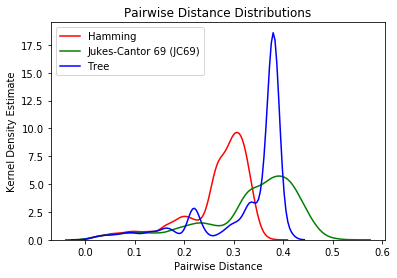

In [8]:
colors = {'Tree':'blue', 'Hamming':'red', 'Jukes-Cantor 69 (JC69)':'green'}
for k in sorted(pairwise_distances.keys()):
    distplot(pairwise_distances[k], kde=True, hist=False, color=colors[k], label=k);
plt.title("Pairwise Distance Distributions");
plt.xlabel("Pairwise Distance");
plt.ylabel("Kernel Density Estimate");

We can also numerically compare these distributions by looking at their averages.

In [9]:
for k in sorted(pairwise_distances.keys()):
    print("Average Pairwise %s Distance: %f" % (k, sum(pairwise_distances[k])/float(len(pairwise_distances[k]))))

Average Pairwise Hamming Distance: 0.264545
Average Pairwise Jukes-Cantor 69 (JC69) Distance: 0.333181
Average Pairwise Tree Distance: 0.324325


Ideally, for two entities *u* and *v*, we would want the pairwise distance between *u* and *v* to be the same whether we are comparing their sequences or comparing them on the true phylogeny. As expected, because of loss of information due to sites that mutate multiple times, the Hamming distance between any two points is significantly lower than the true phylogenetic distance, and although the JC69 correction brings these pairwise sequence distances closer to their true phylogenetic values, it's not perfect.

We can observe this more closely by looking at a plot of pairwise sequence distances vs. pairwise tree distances.

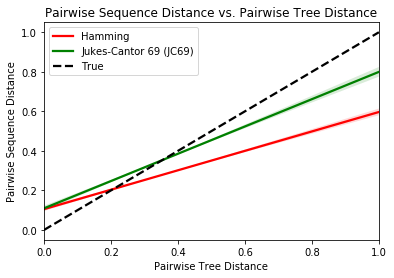

In [10]:
for k in ['Hamming','Jukes-Cantor 69 (JC69)']:
    ax = regplot(x=pairwise_distances['Tree'], y=pairwise_distances[k], color=colors[k], label=k, scatter=False);
regplot(x=pairwise_distances['Tree'], y=pairwise_distances['Tree'], color='black', label='True', scatter=False, line_kws={'linestyle':'--'})
plt.title("Pairwise Sequence Distance vs. Pairwise Tree Distance");
plt.xlabel("Pairwise Tree Distance");
plt.ylabel("Pairwise Sequence Distance");
ax.legend(loc="best");

---

**Author:** [Niema Moshiri](https://niema.net/), UC San Diego, October 2, 2018

---